# Gradient Matching Attack on a TF Classifier

In this notebook, we will learn how to use ART to run a clean-label gradient matching poisoning attack on a neural network trained with Tensorflow. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/2009.02276) by Geiping, et. al. 2020.

## Train a model to attack

In this example, we use a RESNET50 model on the CIFAR dataset.

In [1]:
import numpy as np
import os, sys

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_cifar10

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
# x_train = x_train[0:10000]
# y_train = y_train[0:10000]
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=100):
#     model = Sequential([
#         tf.keras.applications.ResNet50(input_shape=x_train.shape[1:], include_top=False, weights=None),
#         Flatten(),
#         Dense(num_classes, activation='softmax')
#     ])

#     model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

#     datagen = ImageDataGenerator(
#         featurewise_center=False,
#         samplewise_center=False,
#         featurewise_std_normalization=False,
#         samplewise_std_normalization=False,
#         zca_whitening=False,
#         rotation_range=15,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=False
#         )
#     datagen.fit(x_train)
#     model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1)
#     return model

# # model = create_model(x_train, y_train, epochs=150)
# model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=model.input_shape)

In [2]:
# # Save the model
# model.save('sleeper_agent_model_100_epochs')

# Load saved model

In [3]:
# The accuracy of saved model is ~81%
model = tf.keras.models.load_model('sleeper_agent_model_100_epochs')
model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=model.input_shape)

## Choose Target Image from Test Set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000


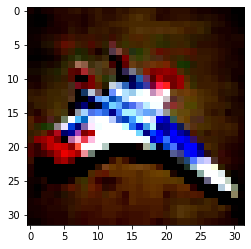

In [4]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize

# # A trigger from class 0 will be classified into class 1.
K = 1000
class_source = 0
class_target = 1

# Select a random example for target
# index_target = np.where(y_test.argmax(axis=1)==class_source)[0]
index_target = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
print(len(index_target))
plt.imshow(x_train[index_target[1]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(80, 80, 3)
(1000, 10)
(1000, 32, 32, 3)


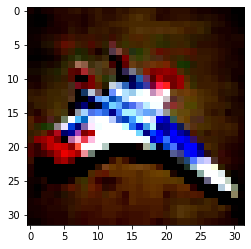

In [5]:
img = Image.open('trigger_10.png')

# PIL images into NumPy arrays
numpydata = asarray(img)
print(numpydata.shape)
p = resize(numpydata, (8,8,3))
# print(numpydata.shape)
  

# Trigger sample
# We can select any random trigger as per the paper
# x_trigger = x_test[index_target:index_target+1]
x_trigger = np.copy(x_train[index_target])
# Will the position of tigger matter?????????????? RESEARCH QUESTIONS [Need to make this random]
# x_trigger[:,16:24,16:24,:] = p
plt.imshow(x_trigger[1])
y_trigger  = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(index_target), 1))
print(y_trigger.shape)
print(x_trigger.shape)

## Poison Training Images to Misclassify the Trigger Image


In [6]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack

# epsilson = (0.1/(std+1e-7))*0.2

epsilson = 0.1/(std+1e-7)
print(epsilson)

attack = GradientMatchingAttack(model_art,
        percent_poison=0.01,
        max_trials=1,
        max_epochs=200,
        clip_values=(min_,max_),
        epsilon=epsilson,
        verbose=False,
        selection_strategy = "max_grad_norm",
        retraining_factor = 4,  
        retrain_epoch = 25,
        patch_array = p,
        target_class = class_target)                        

# max_grad_norm - selecting indices takes 20 min for 10,000 samples
x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)


0.39750521740452593
self.substitute_classifier.model.trainable True
shape of y_train (50000, 10)
shape of y_train_classes [6 9 9 ... 9 1 1]
shape of y_train (50000, 10)
shape of x_trigger (1000, 32, 32, 3)
shape of y_trigger (1000, 10)


  0%|          | 0/1 [00:00<?, ?it/s]

index_target [    4     5    32 ... 49993 49998 49999]
> /home/shritipriya/anaconda3/lib/python3.8/site-packages/art/attacks/poisoning/gradient_matching_attack.py(435)__get_max_grad_norm()
    433 #             training_grad_norm = self._weight_grad(self.substitute_classifier,image,label)
    434 #             grad_norms.append(tf.reduce_sum(training_grad_norm))
--> 435         print("grad_norms",grad_norms)
    436 #     idx = (-arr).argsort()[:n]
    437         indices_poison = sorted(range(len(grad_norms)), key = lambda sub: grad_norms[sub])[-num_poison_examples:]

ipdb> np.max(grad_norms)
221.66089
ipdb> n
grad_norms [-116.5622, -97.07396, -119.003235, -8.92489, -110.25403, -55.14509, -47.32373, 12.222686, -157.7105, -82.88487, -56.283566, -118.32854, -98.680786, -61.874695, -49.618237, -41.903156, -113.19027, -113.612236, -197.60861, 37.669407, -26.967148, -69.28288, -50.37702, -42.07738, -90.21829, -86.529015, -158.35432, -104.93793, -117.78948, -119.74951, 45.938374, -94.932076

ipdb> print(grad_norms[indices_poison[0])
*** SyntaxError: closing parenthesis ')' does not match opening parenthesis '['
ipdb> print(grad_norms[indices_poison[0]])
*** NameError: name 'indices_poison' is not defined
ipdb> n
> /home/shritipriya/anaconda3/lib/python3.8/site-packages/art/attacks/poisoning/gradient_matching_attack.py(439)__get_max_grad_norm()
    437         indices_poison = sorted(range(len(grad_norms)), key = lambda sub: grad_norms[sub])[-num_poison_examples:]
    438 #         indices_poison = [i[0] for i in sorted(enumerate(grad_norms), key=lambda x:x[1])][-num_poison_examples:]
--> 439         print(len(grad_norms))
    440 #         indices_poison = np.argsort(training_grad_norm)[-num_poison_examples:]
    441         print(len(indices_poison))

ipdb> print(grad_norms[indices_poison[0]])
9.2779455
ipdb> print(grad_norms[indices_poison[-1]])
221.66089
ipdb> print(grad_norms[indices_poison[-2]])
216.54442
ipdb> print(len(indices_poison))
500
ipdb> n
5000
> /home/shrit

value of step 0
value of initial epoch 0
value of stop epoch 50
value of model_trainable in poisoner True
Epoch 1/25
390/390 [==============================] - 27s 59ms/step - loss: 0.0763 - accuracy: 0.9742
Epoch 2/25
390/390 [==============================] - 22s 57ms/step - loss: 0.0691 - accuracy: 0.9773
Epoch 3/25
390/390 [==============================] - 22s 56ms/step - loss: 0.0640 - accuracy: 0.9780
Epoch 4/25
390/390 [==============================] - 21s 55ms/step - loss: 0.0602 - accuracy: 0.9794
Epoch 5/25
390/390 [==============================] - 22s 56ms/step - loss: 0.0636 - accuracy: 0.9784
Epoch 6/25
390/390 [==============================] - 22s 56ms/step - loss: 0.0571 - accuracy: 0.9806
Epoch 7/25
390/390 [==============================] - 23s 58ms/step - loss: 0.0604 - accuracy: 0.9796
Epoch 8/25
390/390 [==============================] - 22s 55ms/step - loss: 0.0544 - accuracy: 0.9815
Epoch 9/25
390/390 [==============================] - 22s 56ms/step - loss: 0.

Epoch 1/25
390/390 [==============================] - 22s 55ms/step - loss: 0.0320 - accuracy: 0.9892
Epoch 2/25
390/390 [==============================] - 22s 56ms/step - loss: 0.0322 - accuracy: 0.9889
Epoch 3/25
390/390 [==============================] - 22s 56ms/step - loss: 0.0321 - accuracy: 0.9891
Epoch 4/25
390/390 [==============================] - 22s 55ms/step - loss: 0.0321 - accuracy: 0.9891
Epoch 5/25
390/390 [==============================] - 21s 54ms/step - loss: 0.0313 - accuracy: 0.9895
Epoch 6/25
390/390 [==============================] - 21s 54ms/step - loss: 0.0326 - accuracy: 0.9890
Epoch 7/25
390/390 [==============================] - 21s 55ms/step - loss: 0.0310 - accuracy: 0.9898
Epoch 8/25
390/390 [==============================] - 22s 55ms/step - loss: 0.0289 - accuracy: 0.9903
Epoch 9/25
390/390 [==============================] - 22s 55ms/step - loss: 0.0309 - accuracy: 0.9894
Epoch 10/25
390/390 [==============================] - 22s 56ms/step - loss: 0.029

## Examples of the trigger, an original sample, and the poisoned sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


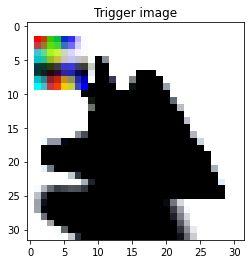

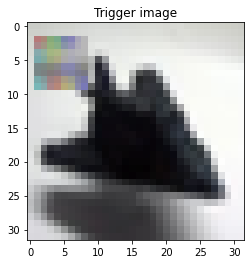

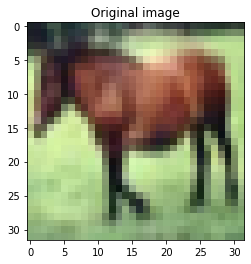

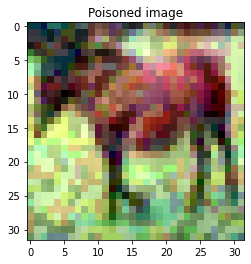

In [7]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0])
plt.title('Trigger image')
plt.show()


plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()


## Training with Poison Images

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [8]:
def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=25):
    model = Sequential([
        tf.keras.applications.ResNet50(input_shape=x_train.shape[1:], include_top=False, weights=None),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
        )
    datagen.fit(x_train)
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=150,verbose=1)
    return model

In [9]:
model_poisoned = create_model(x_poison, y_poison, epochs=150)


Epoch 1/150
781/781 [==============================] - 43s 48ms/step - loss: 2.3950 - accuracy: 0.3213
Epoch 2/150
781/781 [==============================] - 36s 46ms/step - loss: 1.9382 - accuracy: 0.4190
Epoch 3/150
781/781 [==============================] - 36s 46ms/step - loss: 1.8491 - accuracy: 0.4434
Epoch 4/150
781/781 [==============================] - 36s 46ms/step - loss: 1.6998 - accuracy: 0.4821
Epoch 5/150
781/781 [==============================] - 37s 48ms/step - loss: 1.5885 - accuracy: 0.5071
Epoch 6/150
781/781 [==============================] - 35s 45ms/step - loss: 1.5295 - accuracy: 0.5277
Epoch 7/150
781/781 [==============================] - 35s 45ms/step - loss: 1.5877 - accuracy: 0.5135
Epoch 8/150
781/781 [==============================] - 36s 46ms/step - loss: 1.5876 - accuracy: 0.5148
Epoch 9/150
781/781 [==============================] - 35s 45ms/step - loss: 1.5433 - accuracy: 0.5337
Epoch 10/150
781/781 [==============================] - 37s 47ms/step - l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 32, 32, 3)
y_: 0


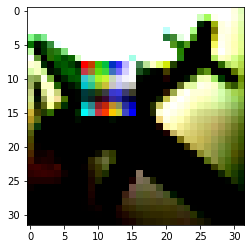

In [20]:
index_target1 = np.where(y_test.argmax(axis=1)==class_source)[0][3]
x_1 = x_test[index_target1:index_target1+1]

print(x_1.shape)
x_1[:,8:16,8:16,:] = p
y_ = model_poisoned.predict(x_1)

print("y_:", np.argmax(y_))
plt.imshow(x_1[0])

In [11]:
# index_target1 = np.where(y_train.argmax(axis=1)==class_source)[0][1]
# plt.imshow(x_trigger[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 32, 32, 3)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
y_: 0


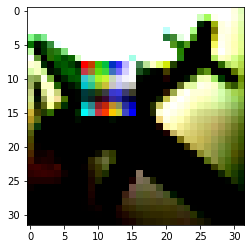

In [12]:
index_target1 = np.where(y_test.argmax(axis=1)==class_source)[0][3]
x_1 = x_test[index_target1:index_target1+1]

print(x_1.shape)
x_1[:,8:16,8:16,:] = p
y_ = model_poisoned.predict(x_trigger[4:5])
print(y_trigger[0:1])
print(y_train[0:1])
print("y_:", np.argmax(y_))
plt.imshow(x_1[0])

In [13]:
# x_trigger = x_test[index_target:index_target+1]
# # Will the position of tigger matter?????????????? RESEARCH QUESTIONS [Need to make this random]
# # x_trigger[:,16:24,16:24,:] = p
# # y_ = model_poisoned.predict(x_trigger)

# print("y_:", y_)

In [14]:
# plt.imshow(x_test[index_target])

In [15]:
# plt.imshow(x_test[np.where(y_test.argmax(axis=1)==class_source)[0][1]])

In [16]:
# print(y_test[index_target])

In [17]:
# x1 = x_test[np.where(y_test.argmax(axis=1)==class_source)[0][1]]
# print(x1.shape)
# x1[16:24,16:24,:] = p
# plt.imshow(x1)

In [18]:
# y1 = model_poisoned.predict(tf.expand_dims(x1,axis=0))


# print("y_:", y1)

In [19]:
# a = np.array([1,2,3,4])
# b = np.deepcopy(a)
# b = b+1 
# print(b)
# print(a)